# Dask Acceleration vs Pandas

This notebook explores speed advantages realized by using the Dask library over Pandas for dataframe operations in Python.

Local system:

| Tech | Version |
| --- | --- |
| Python | 3.6.9 |
| jupyter-notebook | 6.0.1 |
| pandas | 1.0.3 |
| dask | 2.17.2 |
| x64 - based PC | i7 - 2.60 GHz |
| RAM | 16.0 GB |

Hat - tip to Saturn Cloud's [Your Practical Guide to Dask](https://www.saturncloud.io/s/practical-guide-to-dask/).

In [60]:
# importing library to measure execution time
import timeit
from timeit import default_timer as timer

# starting timer for complete notebook execution
notebook_start = timer()

In [61]:
# importing required libraries
import random
import pandas as pd
import os # for directory operations

__Randomize stock data in Python and save the data as a Pandas dataframe.__

In [62]:
# instantiating 1M random stock records
num_rows = 1000000

symbols = ["AAPL", "AMD", "GOOG", "MSFT", "NVDA"]
prices = [random.randint(1, 500) for _ in range(50)]

In [63]:
def get_stock_data(symbols, prices):
    '''
    function to generate random stock data from the
    `symbols` list and the randomized `prices` list
    '''
    return {"symbol": random.sample(symbols, 1)[0],
            "price": random.sample(prices, 1)[0]}

In [64]:
# using the function to generate stock data for the
# number of rows instantiated in `num_rows`
stock_data = [get_stock_data(symbols, prices) for _ in range(num_rows)]

# instantiate data as a pandas dataframe
stock_df = pd.DataFrame(stock_data,
                        columns=["symbol", "price"])

__Export stock data to a csv file.__

In [65]:
# save `stock_df` as a csv file in the data subdirectory
if not os.path.exists('data'):
    os.makedir('data')

# prefix filename with '__rc__' to .gitignore
stock_df.to_csv("data/_rc_stock_data.csv")

# preview the dataframe
stock_df.head()

,symbol,price
0,MSFT,245
1,AAPL,278
2,NVDA,313
3,GOOG,438
4,NVDA,20


## Load csv Data to a Dask Dataframe

In [66]:
import dask.dataframe as dd

# loading csv data to a dask dataframe
dask_df = dd.read_csv("data/_rc_stock_data.csv")

# how long did that take
%time len(dd.read_csv("data/_rc_stock_data.csv"))

Wall time: 209 ms


1000000

__Repartition dask data to sizes of 100MB-or-less, per [official documentation](https://docs.dask.org/en/latest/dataframe-best-practices.html#repartition-to-reduce-overhead)__.

In [67]:
# repartitioning dask dataframe from csv
dask_df = dask_df.repartition(partition_size="100MB")

# how long did that take
%time len(dask_df.repartition(partition_size="100MB"))

Wall time: 2.8 s


1000000

## Load csv Data to a Pandas Dataframe

In [68]:
# loading pandas dataframe from csv
pandas_df = pd.read_csv("data/_rc_stock_data.csv")

# how long did that take
%time len(pd.read_csv("data/_rc_stock_data.csv"))

Wall time: 182 ms


1000000

## Compute CPU Acceleration with Dask vs Pandas

### Calculate Mean

__Create functions to calculate mean for the same dataframe in each of the two libraries.__

In [69]:
def pandas_mean():
    '''Calculates mean using pandas
    ''' 
    pandas_df["price"].mean()
    
def dask_mean():
    '''Calculate means using dask
    ''' 
    dask_df["price"].mean()

In [70]:
times_dict = {}

__Compare Calculating Means (single iteration)__

In [71]:
# times_dict.update( {'pandas_1' : .0, 'dask_1' : .0} )

In [72]:
# times_dict['pandas_1'] = round(timeit.timeit(pandas_mean, number=1), 5)
# print("\npandas execution time: ", times_dict['pandas_1'])
# print("-"*30)

# times_dict['dask_1'] = round(timeit.timeit(dask_mean, number=1), 5)
# print("\ndask execution time: ", times_dict['dask_1'])

__Compute and compare task execution with `timer()`__

In [73]:
# time pandas computation
start = timer()
# calculating mean using pandas
pandas_df["price"].mean()
end = timer()

# print time elapsed in seconds
pandas_mean_1x = round(end - start, 5)
print("pandas execution time: ", pandas_mean_1x)
print("-"*30)

# time dask computation
start = timer()
# calculating mean using Dask
dask_df["price"].mean()
end = timer()
# print time elapsed in seconds
dask_mean_1x = round(end - start, 5)

# print time elapsed in seconds
print("\ndask execution time: ", dask_mean_1x)

pandas execution time:  0.00156
------------------------------

dask execution time:  0.00152


__Plot: Compare Computation Duration__

In [74]:
# importing necessary library
import matplotlib.pyplot as plt
%matplotlib inline

Build a function for plotting.

In [75]:
def plot_comparison(p, d, title):
    """
    Takes comparable operation times for pandas (p)
    and dask (d) and creates a bar plot
    """
    # adding title and lables
    fig, ax = plt.subplots()
    plt.title(title)
    plt.ylabel("Seconds")
    plt.xlabel("library")

    # building the plot
    langs = ['pandas', 'dask']
    delay = [p, d]
    ax.bar(langs, delay)
    return plt.show()

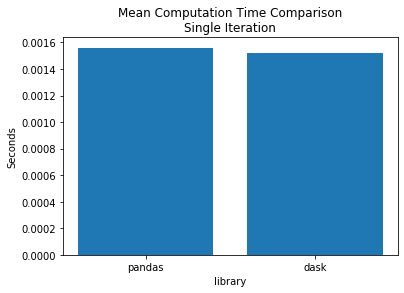

In [76]:
plot_comparison(pandas_mean_1x, 
                dask_mean_1x, 
                "Mean Computation Time Comparison\nSingle Iteration")

__Compare Calculating Means (10K iterations)__

In [77]:
pandas_mean_10k = round(timeit.timeit(pandas_mean, number=10000), 2)
print("\npandas execution time: ", pandas_mean_10k)
print("-"*30)

dask_mean_10k = round(timeit.timeit(dask_mean, number=10000), 2)
print("\ndask execution time: ", dask_mean_10k)


pandas execution time:  8.95
------------------------------

dask execution time:  10.28


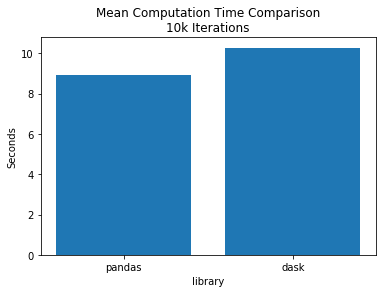

In [78]:
plot_comparison(pandas_mean_10k, 
                dask_mean_10k, 
                "Mean Computation Time Comparison\n10k Iterations")

__Compare Calculating Means (100K iterations)__

In [79]:
pandas_mean_100k = round(timeit.timeit(pandas_mean, number=100000), 2)
print("\npandas execution time: ", pandas_mean_100k)
print("-"*30)

dask_mean_100k = round(timeit.timeit(dask_mean, number=100000), 2)
print("\ndask execution time: ", dask_mean_100k)

print("\nCalculating means is about",
      round((pandas_mean_100k - dask_mean_100k) / dask_mean_100k*100, 2),
      "% faster over a large dataset, with dask on CPU.")


pandas execution time:  92.37
------------------------------

dask execution time:  109.24

Calculating means is about -15.44 % faster over a large dataset, with dask on CPU.


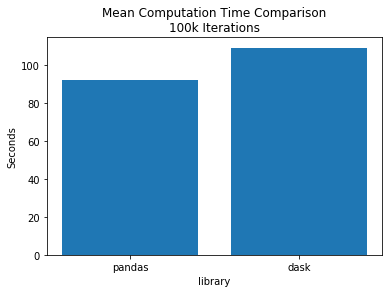

In [80]:
plot_comparison(pandas_mean_100k, 
                dask_mean_100k, 
                "Mean Computation Time Comparison\n100k Iterations")

### Filter Dataframe

__Create functions to filter dataframe in each of the two libraries.__

In [33]:
def pandas_filter():
    '''Filters by price using pandas
    ''' 
    pandas_df[pandas_df["price"] > 250]
    
def dask_filter():
    '''Filters by price using dask
    ''' 
    dask_df[dask_df["price"] > 250]

__Compare Filtering Dataframes (single iteration)__

In [34]:
print("\npandas execution time: ", round(
    timeit.timeit(pandas_filter, number=1), 5)
     )
print("-"*30)

print("\ndask execution time: ", round(
    timeit.timeit(dask_filter, number=1), 5)
     )


pandas execution time:  0.02528
------------------------------

dask execution time:  0.00095


In [35]:
# computing and comparing task execution with `timer()`
start_p = timer()
# Filtering by price in Pandas
pandas_df[pandas_df["price"] > 250]
end_p = timer()
pandas_time = round(end_p - start_p, 5)

print("pandas execution time: ", pandas_time)
print("-"*30)

start_d = timer()
# Filtering by price in Dask
dask_df[dask_df["price"] > 250]
end_d = timer()
dask_time = round(end_d - start_d, 5)

print("\ndask execution time: ", dask_time)

pandas execution time:  0.02231
------------------------------

dask execution time:  0.00101


__Compare Filtering Dataframes (10K iterations)__

In [36]:
print("\npandas execution time: ", round(
    timeit.timeit(pandas_filter, number=10000), 2)
     )
print("-"*30)

print("\ndask execution time: ", round(
    timeit.timeit(dask_filter, number=10000), 2)
     )


pandas execution time:  186.23
------------------------------

dask execution time:  6.79


__Compare Filtering Dataframes (100K iterations)__

In [37]:
# computing filter time
p_filter = round(timeit.timeit(pandas_filter, number=100000), 2)

print("\npandas execution time: ", p_filter)
print("-"*30)

d_filter = round(timeit.timeit(dask_filter, number=100000), 2)

print("\ndask execution time: ", d_filter)


pandas execution time:  1873.04
------------------------------

dask execution time:  68.34


In [38]:
# comparing filter execution time
print("\nFiltering is about",
      round((p_filter - d_filter) / p_filter*100, 2),
      "% faster over a large dataset, with dask on CPU.")


Filtering is about 96.35 % faster over a large dataset, with dask on CPU.


### Add Dataframes

__Create functions to add dataframes in each of the two libraries.__

In [39]:
def pandas_add():
    '''Adds dataframes together using pandas
    ''' 
    pandas_df + pandas_df + pandas_df + pandas_df + pandas_df
    
def dask_add():
    '''Adds dataframes together using dask
    ''' 
    dask_df + dask_df + dask_df + dask_df + dask_df

__Compare Adding Dataframes (single iteration)__

In [40]:
print("\npandas execution time: ", round(
    timeit.timeit(pandas_add, number=1), 5)
     )
print("-"*30)

print("\ndask execution time: ", round(
    timeit.timeit(dask_add, number=1), 5)
     )


pandas execution time:  0.43025
------------------------------

dask execution time:  0.02012


In [41]:
start_p = timer()
# adding big dataframes in pandas
pandas_df + pandas_df + pandas_df + pandas_df + pandas_df
end_p = timer()
pandas_time = round(end_p - start_p, 5)
print("pandas execution time: ", pandas_time)
print("-"*30)

start_d = timer()
# adding big dataframes in dask
dask_df + dask_df + dask_df + dask_df + dask_df
end_d = timer()
dask_time = round(end_d - start_d, 5)
print("\ndask execution time: ", dask_time)

# calculating dask speed improvement
print("-"*30, "\n")

print(round((pandas_time - dask_time) / pandas_time*100, 3), 
      "% increase in speed")

pandas execution time:  0.39475
------------------------------

dask execution time:  0.01891
------------------------------ 

95.21 % increase in speed


__Compare Adding Dataframes (10K iterations)__

In [42]:
# compute
p_add = timeit.timeit(pandas_add, number=10000)

print("\npandas execution time: ", round(
    p_add, 2)
     )
print("-"*30)

d_add = timeit.timeit(dask_add, number=10000)

print("\ndask execution time: ", round(
    d_add, 2)
     )

print("\nAdding dataframes is about",
      round((p_add - d_add) / p_add*100, 2),
      "% faster over a large dataset, with dask on CPU.")


pandas execution time:  4017.73
------------------------------

dask execution time:  190.97

Adding dataframes is about 95.25 % faster over a large dataset, with dask on CPU.


In [43]:
# ending timer for complete notebook execution
notebook_end = timer()

# calculating time for complete notebook execution
notebook_duration = notebook_end - notebook_start
print(round(notebook_duration, 2))

6632.79


__Compare Adding Dataframes (100K iterations)__

In [45]:
# compute
# --time prohibitive--
# p_add = timeit.timeit(pandas_add, number=100000)

# compute for dask, only, in seconds
d_add = timeit.timeit(dask_add, number=100000)
d_add

1948.6294115

In [50]:
# print("\npandas execution time: ", round(
#     p_add, 2)
#      )
# print("-"*30)

print("\ndask execution time: ", round(
    d_add), 2)

print("\nAdding dataframes takes about",
      round(d_add/60, 2),
      "minutes over the large datasets, with dask on CPU.")


dask execution time:  1949 2

Adding dataframes takes about 32.48 minutes over the large datasets, with dask on CPU.


======================================================

## Compute GPU Acceleration with Dask vs Pandas

__The cuDF library enables GPU acceleration for Pandas - Dask dataframe computation.__

In [ ]:
# import cudf

# # reinstantiate `dask_df` for use with GPU backend
# dask_df = dask_df.map_partitions(cudf.from_pandas) 

### ======_cuDF no longer available via pip [or for Windows???]_ ======

__Resume in containerized environment.__

In [ ]:
# ending timer for complete notebook execution
notebook_end = timer()

# calculating time for complete notebook execution
notebook_duration = notebook_end - notebook_start
print(round(notebook_duration, 2))

# ---